# Построение скоринговой модели бинарной классифкации по данным Home credit bank

План работы для анализа только данные application
1. Смотрим на признаки в целом (типы, размер и пропущенные значения)
2. Исследуем признаки по отдельности, заполняя пропуска и может быть создавая новые для количественных
3. Исследуем признаки на коллиниарность, отмечая те, которые сильно зависимые, потом может сплющим, если поможет
4. Кодируем категориальныех признаки (если надумаем не бустинг)
5. Убираем таргет, загоняем в модель LGBM, фитим
6. Проверяем на метриках
7. Смотрим на самые важные

## 1 ЗАГРУЗКА И ОБЩИЙ АНАЛИЗ

In [62]:
# загрузим базовые библиотеки для начала
import pandas as pd
import numpy as np


In [63]:
df_train = pd.read_csv(r'C:\Users\user\Desktop\HCB\application_train.csv')
df_test = pd.read_csv(r'C:\Users\user\Desktop\HCB\application_test.csv')

Смотрим на тренирочные данные

In [64]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [66]:
df_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


122 признака, 16 категориальных, таргет включена, бинарная классификация, может быть логистичекая регрессия тоже подойдет?

In [67]:
df_train.select_dtypes(include=[object]).apply(pd.Series.unique, axis = 0)

NAME_CONTRACT_TYPE                                [Cash loans, Revolving loans]
CODE_GENDER                                                         [M, F, XNA]
FLAG_OWN_CAR                                                             [N, Y]
FLAG_OWN_REALTY                                                          [Y, N]
NAME_TYPE_SUITE               [Unaccompanied, Family, Spouse, partner, Child...
NAME_INCOME_TYPE              [Working, State servant, Commercial associate,...
NAME_EDUCATION_TYPE           [Secondary / secondary special, Higher educati...
NAME_FAMILY_STATUS            [Single / not married, Married, Civil marriage...
NAME_HOUSING_TYPE             [House / apartment, Rented apartment, With par...
OCCUPATION_TYPE               [Laborers, Core staff, Accountants, Managers, ...
WEEKDAY_APPR_PROCESS_START    [WEDNESDAY, MONDAY, THURSDAY, SUNDAY, SATURDAY...
ORGANIZATION_TYPE             [Business Entity Type 3, School, Government, R...
FONDKAPREMONT_MODE            [reg oper 

Категориальные поля можно будет закодировать, но это очень сильно замедлит модель, поэтому попробуем просто LGBM

In [68]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


в тестовой выборке 121 поле, без таргета

Посмотрим на пропуски в целом по дата фрейму

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

[Text(0.5, 1.0, 'Диаграмма 1 Пропущеные значения')]

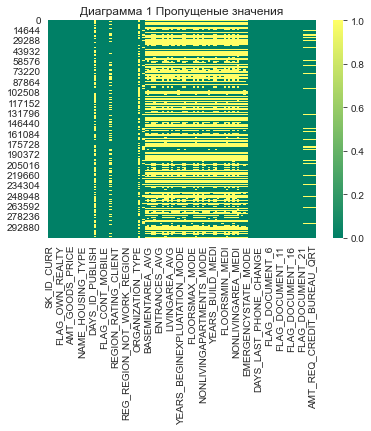

In [70]:
sns.heatmap(df_train.isnull(), cmap = 'summer').set(title='Диаграмма 1 Пропущеные значения')

In [71]:
miss_total = df_train.isnull().sum()

In [72]:
miss_per = 100 * miss_total/len(df_train)
miss_per.value_counts(ascending = False)

0.000000     55
13.501631     6
0.332021      4
49.760822     3
66.497784     3
55.179164     3
69.432963     3
50.193326     3
68.354953     3
59.376738     3
67.848630     3
53.295980     3
69.872297     3
50.348768     3
48.781019     3
50.749729     3
58.515956     3
68.386172     1
0.000325      1
65.990810     1
47.398304     1
50.840783     1
48.268517     1
50.176091     1
31.345545     1
0.000650      1
56.381073     1
0.214626      1
19.825307     1
0.420148      1
0.003902      1
0.090403      1
dtype: int64

По многим полям порядка 70% незаполненных значений - мы ничего не будем пока делать, чтобы не внести дополнительный вес фичей, которые в реальности не имеют отношения к определению целевой метрики, единственное - надо посмотреть, совпадают ли пропуски в тесте с train - **но как?**

Посмотрим есть ли дисбаланс классов в таргете

In [73]:
df_train['TARGET'].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

[Text(0.5, 1.0, 'Диаграмма 2 Распределение таргета')]

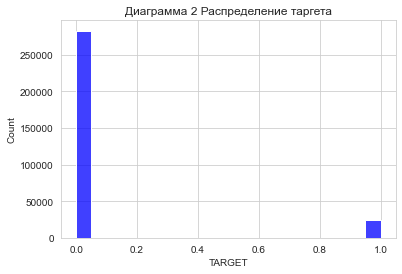

In [74]:
sns.histplot(df_train['TARGET'], color = "blue").set(title = 'Диаграмма 2 Распределение таргета')

Очевидный дисбаланс, порядка 92% приходится на 0 - без дефолта, возвращают кредит. Дисбаланс не всегда есть хорошо - **как задел для повышения качества модели**

## 2. Исследование признаков

Полей очень много, все исследовать не получиться, нужно определить какие фичи наиболее всего зависят от таргета, и уже их непосредственно исследовать

In [75]:
corr_features = df_train.corr()['TARGET'].sort_values()
corr_features

EXT_SOURCE_3                  -0.178919
EXT_SOURCE_2                  -0.160472
EXT_SOURCE_1                  -0.155317
DAYS_EMPLOYED                 -0.044932
FLOORSMAX_AVG                 -0.044003
                                 ...   
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, Length: 106, dtype: float64

In [76]:
# мои мучения с построением матрицы коллиниарности -  не получается
#object_columns = [s for s in df_train.columns if df_train[s].dtypes == 'object']
#df_corr = df_train.drop(object_columns, axis=1, inplace=True)
#df_corr_1 = df_corr()['TARGET']

In [77]:
#sns.heatmap(df_corr.corr()['TARGET'], cmap="YlGnBu", annot = True)
#plt.show()


Корреляции нам показывает на признаки, которые стоит анализировать прежде всего:
Наибольшая положительная корреляция (возьмем первые 5):
- DAYS_BIRTH возраст
- REGION_RATING_CLIENT_W_CITY - рейтинг клиента в городе
- REGION_RATING_CLIENT - рейтинг клиента в регионе
- DAYS_LAST_PHONE_CHANGE - дата последнего смена телефона
- DAYS_ID_PUBLISH - публикация ID (?)
Наибольшая отрицательная корреляция (возьмем первые 3): непонятно пока что это такое
- EXT_SOURCE_3
- EXT_SOURCE_2
- EXT_SOURCE_1

### 2.1 Исследуем признаки с отрицательной корреляцией

Text(0.5, 1.0, 'Диаграмма Распределение признака EXT_SOURCE_3')

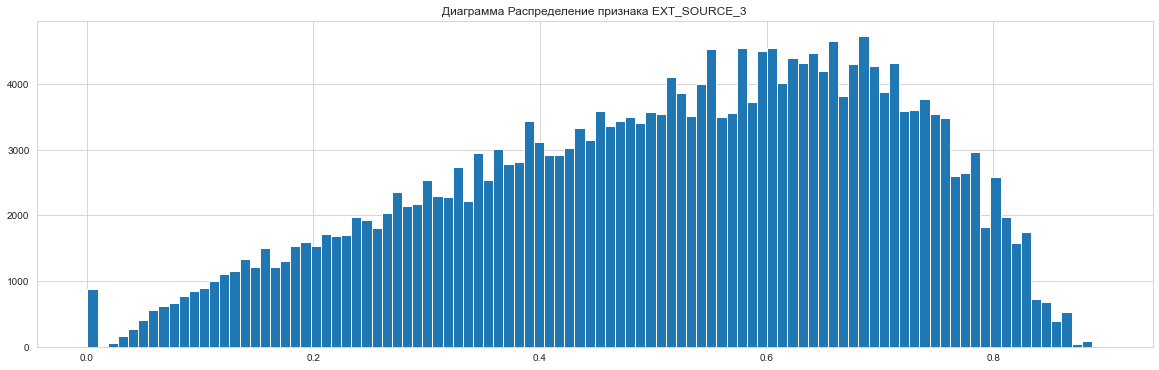

In [78]:
plt.rcParams['figure.figsize'] = (20,6)
df_train['EXT_SOURCE_3'].hist(bins=100)
plt.title('Диаграмма Распределение признака EXT_SOURCE_3')

Text(0.5, 1.0, 'Диаграмма Распределения признака EXT_SOURCE_2')

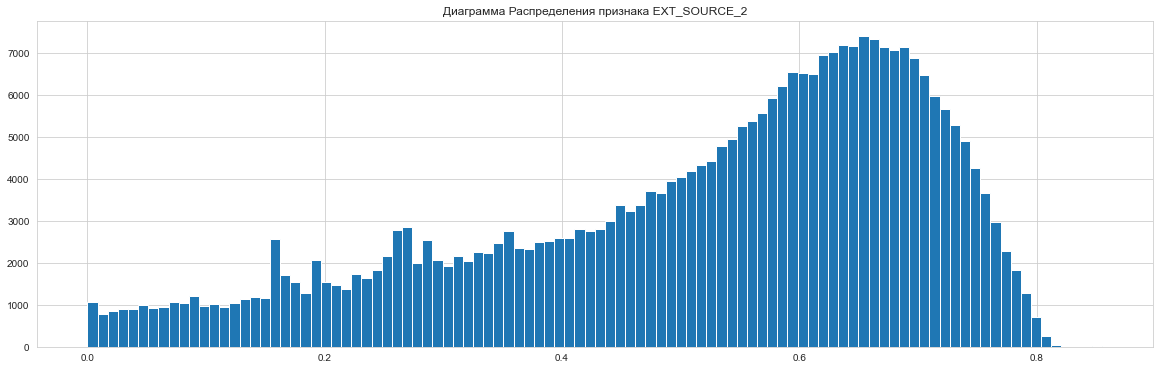

In [79]:
plt.rcParams['figure.figsize'] = (20,6)
df_train['EXT_SOURCE_2'].hist(bins=100)
plt.title('Диаграмма Распределения признака EXT_SOURCE_2')

Text(0.5, 1.0, 'Диаграмма Распределения признака EXT_SOURCE_2')

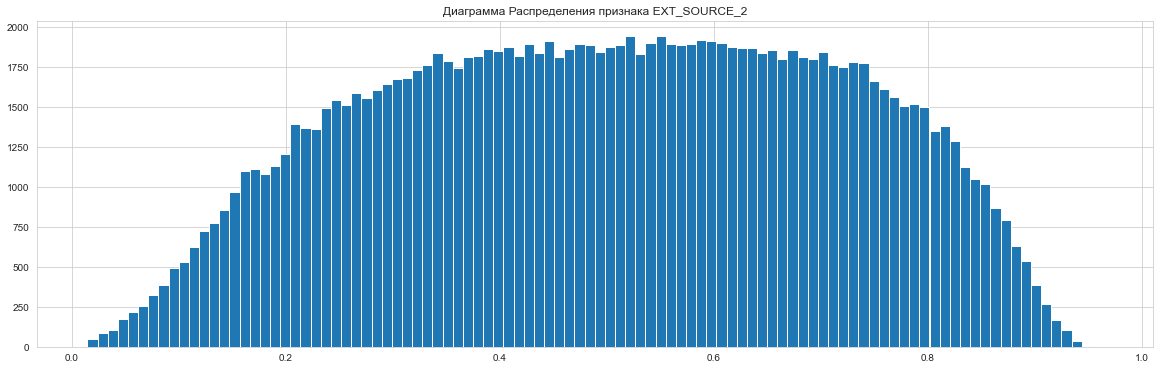

In [80]:
plt.rcParams['figure.figsize'] = (20,6)
df_train['EXT_SOURCE_1'].hist(bins=100)
plt.title('Диаграмма Распределения признака EXT_SOURCE_2')

**Тут не понятно, как настроить распределения в разрезе дефолт/вернул**

в силу того, что превалирует класс 0 (выплатил), скорее всего диаграммы показывают нам, что с ростом их показателя, вероятность выплаты повышается, посмотрим на матрицу корреляции через heatmap

[Text(0.5, 1.0, 'матрица корреляции 1')]

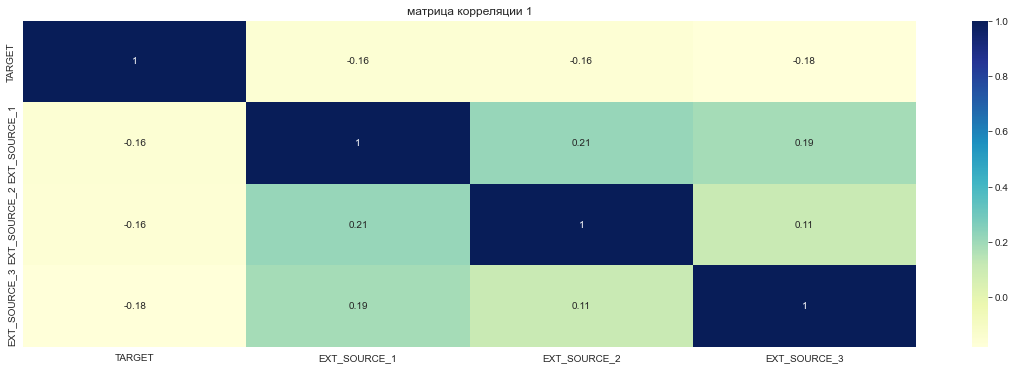

In [81]:
sns.heatmap(df_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].corr(), cmap="YlGnBu", annot = True).set(title = 'матрица корреляции 1')

Ну вот видим, что этим признаки положительно коррелируют с собой, не критично конечно, но запомним это.
Посмотрим как все выбранные признаки (8 ед) коррелируют между собой.

[Text(0.5, 1.0, 'матрица корреляции 1')]

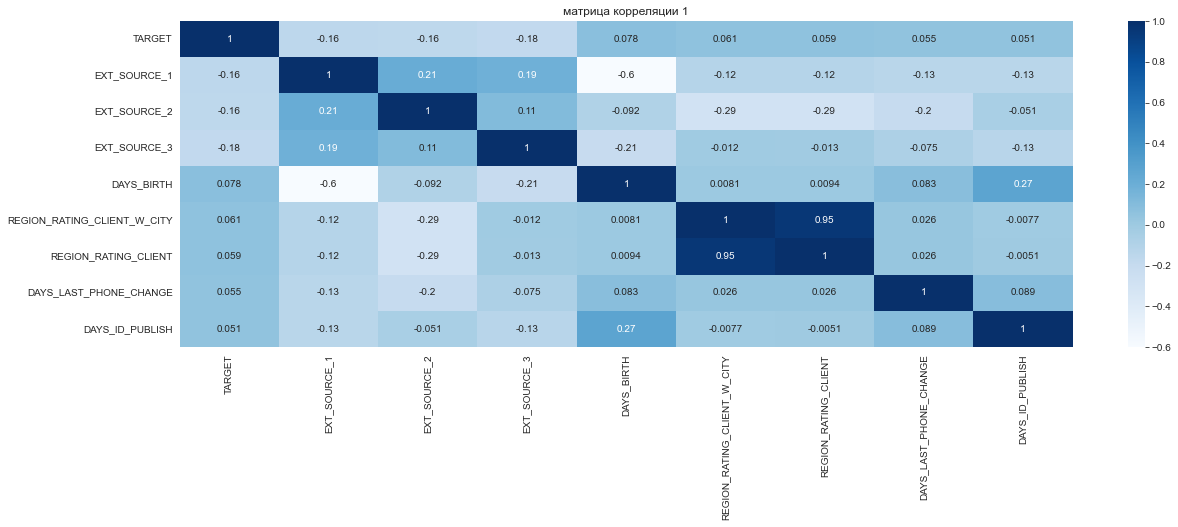

In [82]:
sns.heatmap(df_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH']].corr(), cmap = "Blues", annot = True).set(title = 'матрица корреляции 1')

Так так,рейтинг региона очень сильно коррелирует с рейтингом клиента в городе, а DAYS_BIRTH имеют сильную обратную корреляцию с EXT_SOURCE_1, вот только что это такое EXT_SOURCE_1? в остальном все нормально вроде.

### 2.2 Исследуем признаки с положительной корреляцией

**Возраст**

In [83]:
df_train['DAYS_BIRTH'].head()

0    -9461
1   -16765
2   -19046
3   -19005
4   -19932
Name: DAYS_BIRTH, dtype: int64

In [84]:
df_train['DAYS_BIRTH'] = abs(df_train['DAYS_BIRTH']/365)

In [85]:
df_train['DAYS_BIRTH'].head()

0    25.920548
1    45.931507
2    52.180822
3    52.068493
4    54.608219
Name: DAYS_BIRTH, dtype: float64

In [86]:
df_train['DAYS_BIRTH'].corr(df_train['TARGET'])

-0.07823930830982713

Так понимаю это возраст заемщиков, перевели из отрицательных дней в года, перезаписали, корреляция сменила знак, но это не критично, потому как логика осталась - отрицательно коррелирует с невозвратом, т.е. чем выше возраст, тем ниже невозврат

Text(0.5, 1.0, 'Диаграмма Распределения признака DAYS_BIRTH')

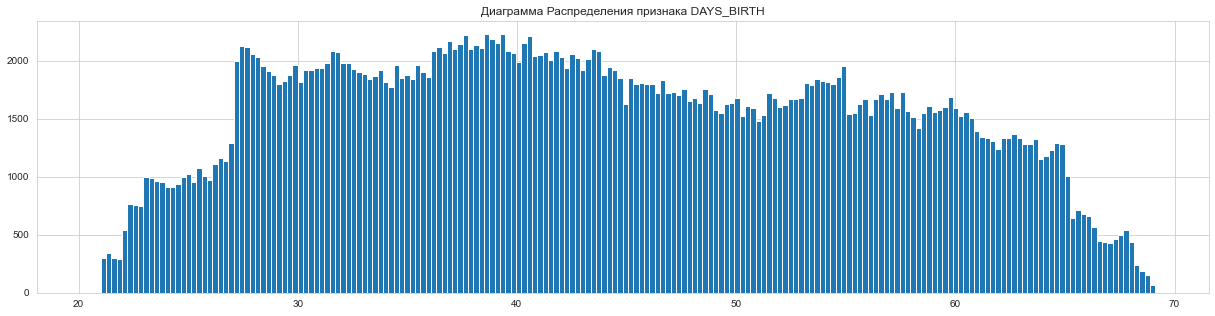

In [87]:
plt.rcParams['figure.figsize'] = (21,5)
df_train['DAYS_BIRTH'].hist(bins=200)
plt.title('Диаграмма Распределения признака DAYS_BIRTH')

<AxesSubplot:>

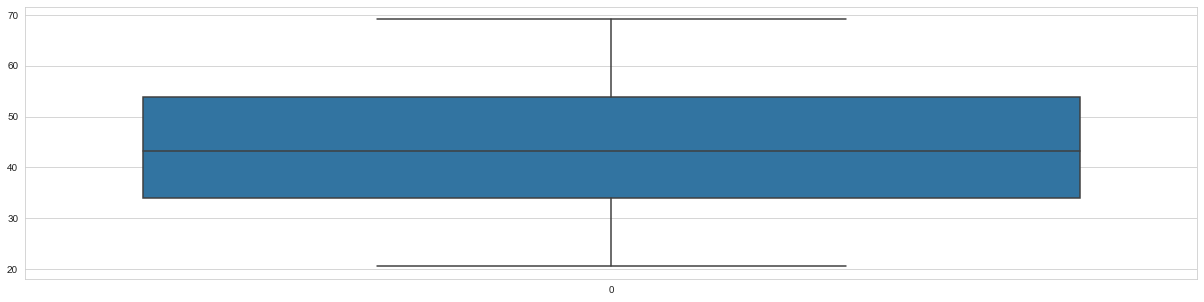

In [88]:
sns.boxplot(data=df_train['DAYS_BIRTH'])

особых выбросов мы не видим, но визуально кажется, что основная масса клиентов у нас с 27 до 60 лет, что в целом логично

**рейтинг клиента в городе**

In [89]:
df_train['REGION_RATING_CLIENT_W_CITY'].head()

0    2
1    1
2    2
3    2
4    2
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64

Text(0.5, 1.0, 'Диаграмма Распределения признака REGION_RATING_CLIENT_W_CITY')

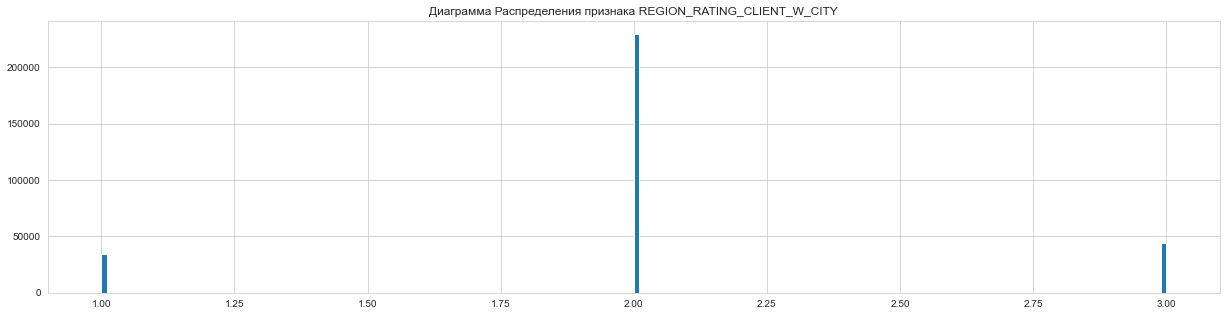

In [90]:
plt.rcParams['figure.figsize'] = (21,5)
df_train['REGION_RATING_CLIENT_W_CITY'].hist(bins=200)
plt.title('Диаграмма Распределения признака REGION_RATING_CLIENT_W_CITY')

<AxesSubplot:>

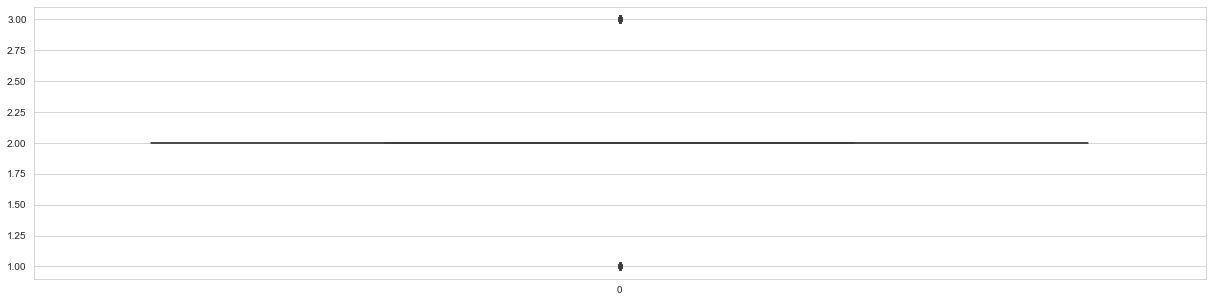

In [91]:
sns.boxplot(data=df_train['REGION_RATING_CLIENT_W_CITY'])

Тут явно какие полярные значения, видимо можно ставить либо 1,2 или 3 (наверное внутрення методика), больше всего клиентов у нас с коэф. 2 - около 74%

In [92]:
df_train['REGION_RATING_CLIENT_W_CITY'].value_counts(normalize=True)

2    0.746263
3    0.142629
1    0.111108
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64

**рейтинг клиента в регионе**
тут такая же картина, неудивительно почему они коррелируют

In [93]:
df_train['REGION_RATING_CLIENT'].value_counts(normalize=True)

2    0.738133
3    0.157165
1    0.104702
Name: REGION_RATING_CLIENT, dtype: float64

Text(0.5, 1.0, 'Диаграмма Распределения признака REGION_RATING_CLIENT')

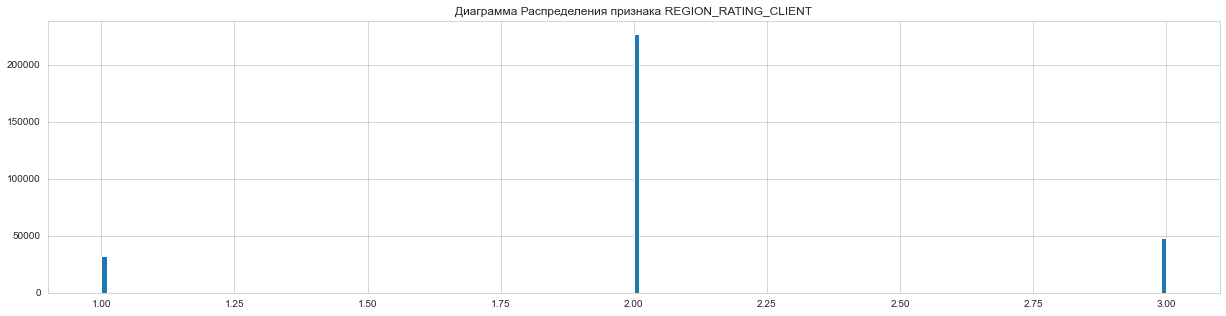

In [94]:
plt.rcParams['figure.figsize'] = (21,5)
df_train['REGION_RATING_CLIENT'].hist(bins=200)
plt.title('Диаграмма Распределения признака REGION_RATING_CLIENT')

**дата последнего смена телефона**

In [95]:
df_train['DAYS_LAST_PHONE_CHANGE'].head()

0   -1134.0
1    -828.0
2    -815.0
3    -617.0
4   -1106.0
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

In [96]:
df_train['DAYS_LAST_PHONE_CHANGE'] = abs(df_train['DAYS_LAST_PHONE_CHANGE']/365)
df_train['DAYS_LAST_PHONE_CHANGE'].head()

0    3.106849
1    2.268493
2    2.232877
3    1.690411
4    3.030137
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

In [97]:
df_train['DAYS_LAST_PHONE_CHANGE'].sort_values(ascending=False)

191568    11.758904
137198    11.465753
294270    11.432877
101177    11.378082
106063    11.317808
            ...    
235186     0.000000
68881      0.000000
235190     0.000000
153756     0.000000
15709           NaN
Name: DAYS_LAST_PHONE_CHANGE, Length: 307511, dtype: float64

Text(0.5, 1.0, 'Диаграмма Распределения признака DAYS_LAST_PHONE_CHANGE')

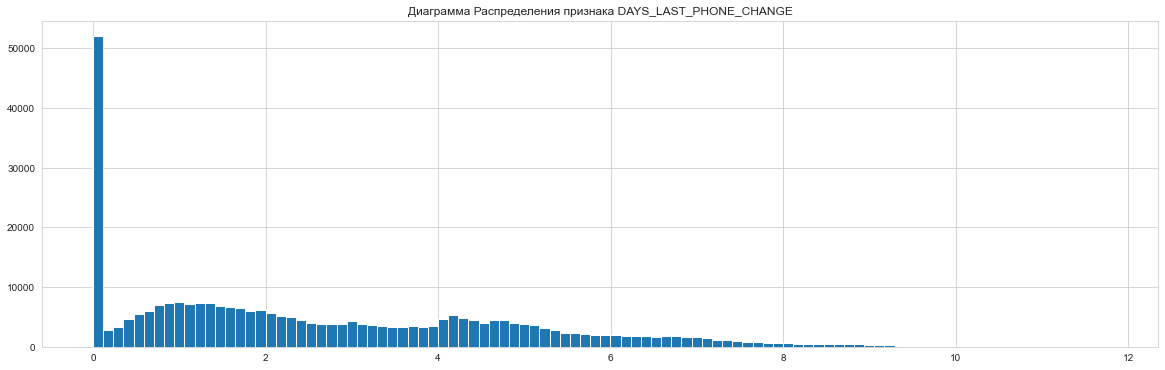

In [98]:
plt.rcParams['figure.figsize'] = (20,6)
df_train['DAYS_LAST_PHONE_CHANGE'].hist(bins=100)
plt.title('Диаграмма Распределения признака DAYS_LAST_PHONE_CHANGE')

График очень очень неприятный((( выбросы...и длинный питон...

**DAYS_ID_PUBLISH**

In [99]:
df_train['DAYS_ID_PUBLISH'].head()

0   -2120
1    -291
2   -2531
3   -2437
4   -3458
Name: DAYS_ID_PUBLISH, dtype: int64

In [100]:
df_train['DAYS_ID_PUBLISH'] = abs(df_train['DAYS_ID_PUBLISH']/365)
df_train['DAYS_ID_PUBLISH'].head()

0    5.808219
1    0.797260
2    6.934247
3    6.676712
4    9.473973
Name: DAYS_ID_PUBLISH, dtype: float64

Text(0.5, 1.0, 'Диаграмма Распределения признака DAYS_ID_PUBLISH')

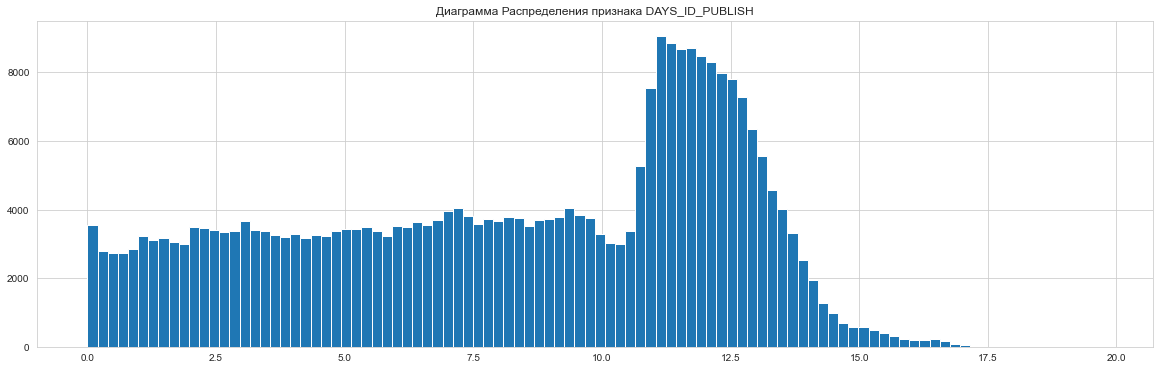

In [101]:
plt.rcParams['figure.figsize'] = (20,6)
df_train['DAYS_ID_PUBLISH'].hist(bins=100)
plt.title('Диаграмма Распределения признака DAYS_ID_PUBLISH')

<AxesSubplot:>

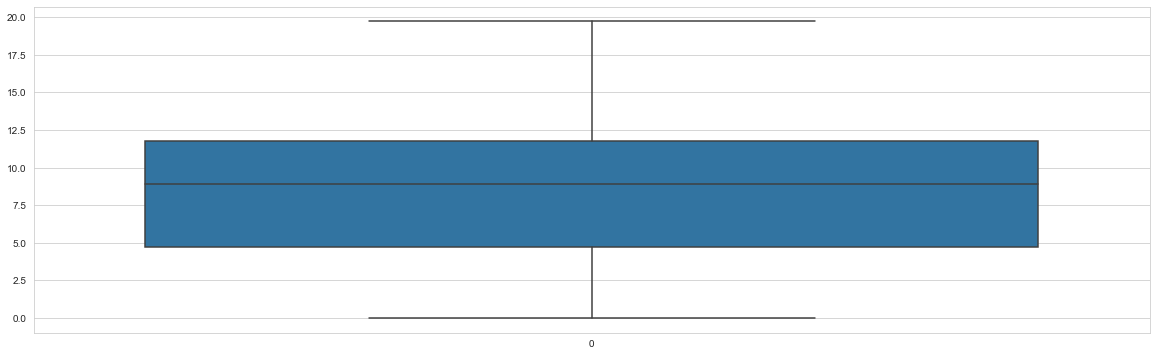

In [102]:
sns.boxplot(data=df_train['DAYS_ID_PUBLISH'])

не особо заметны выбросы, но график явно не традиционной ориентации

## 3. Отправляем в модель

In [103]:
!pip install lightgbm

In [104]:
from lightgbm import LGBMClassifier

In [105]:
# уберем таргет из тренировочной выборки, категориальные фичи он должен съесть
target = df_train['TARGET']
train = df_train.drop(labels= ['TARGET'], axis = 1)

In [106]:
train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
test = df_test
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

print('Тренировочная выборка', train.shape)
print('Тестовая выборка', test.shape) # уберем в трайн столбцы, которых нет в тестовой

Тренировочная выборка (307511, 245)
Тестовая выборка (48744, 242)


In [109]:
train, test = train.align(train, join = 'inner', axis = 1)

print('Тренировочная выборка', train.shape)
print('Тестовая выборка', test.shape)


Тренировочная выборка (307511, 245)
Тестовая выборка (307511, 245)


In [110]:
#model = LGBMClassifier() # попробуем с базовыми настройками, а потом может добавим что-нибудь
#model.fit(train, target, eval_metric=['auc'])

In [111]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terracedhouse,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,-637,-3648.0,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.931507,-1188,-1186.0,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,52.180822,-225,-4260.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,52.068493,-3039,-9833.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,54.608219,-3038,-4311.0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terracedhouse,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,-637,-3648.0,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.931507,-1188,-1186.0,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,52.180822,-225,-4260.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,52.068493,-3039,-9833.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,54.608219,-3038,-4311.0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
model = LGBMClassifier() # попробуем с базовыми настройками, а потом может добавим что-нибудь
model.fit(train, target, eval_metric=['auc'])

LGBMClassifier()

In [114]:
predict = model.predict_proba(test)[:, 1] # сохраняем вероятности только для положительного исхода

In [115]:
from sklearn.metrics import accuracy_score, roc_auc_score
metrics = roc_auc_score(target, predict)
print('LightGBM: ROC AUC=%.3f' % (metrics))

LightGBM: ROC AUC=0.794


In [124]:
!pip install shap

In [129]:
#import shap
#explainer = shap.Explainer(model)
#shap_values = explainer(train)

#shap.plots.beeswarm(shap_values)

ValueError: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!

Добавляем бюро

In [116]:
bureau = pd.read_csv('bureau.csv')
bureau.head(7)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.0,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.8,42103.80,0.00,0.0,Consumer credit,-22,NaN


In [117]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [118]:
bureau.select_dtypes(include=[object]).apply(pd.Series.unique, axis = 0)

CREDIT_ACTIVE                       [Closed, Active, Sold, Bad debt]
CREDIT_CURRENCY     [currency 1, currency 2, currency 4, currency 3]
CREDIT_TYPE        [Consumer credit, Credit card, Mortgage, Car l...
dtype: object

[Text(0.5, 1.0, 'Диаграмма Пропущеные значения')]

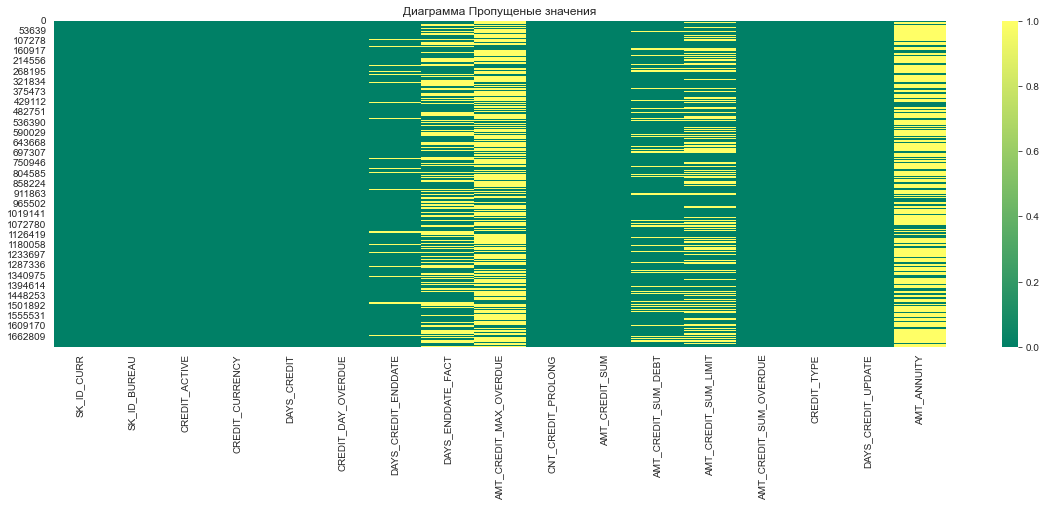

In [119]:
sns.heatmap(bureau.isnull(), cmap = 'summer').set(title='Диаграмма Пропущеные значения')

Несмотря на большое количество пропусков, LGBM хорошо с ними справляется,

In [120]:
# закодируем
bur = pd.get_dummies(bureau)

print('Бюро', train.shape)

Бюро (307511, 245)


In [121]:
bur.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
bur.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,...,0,0,0,0,0,0,0,0,0,0
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,...,0,0,0,0,0,0,0,0,0,0
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [122]:
train_2 = train.merge(right=bur.reset_index(), how='left', on='SK_ID_CURR')
test_2 = test.merge(right=bur.reset_index(), how='left', on='SK_ID_CURR')

In [127]:
train_2.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,-637,-3648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,-637,-3648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,-637,-3648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,-637,-3648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,-637,-3648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
test_2.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,-637,-3648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,-637,-3648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,-637,-3648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,-637,-3648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,-637,-3648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
model_2 = LGBMClassifier()
model_2.fit(train_2, target, eval_metric=['auc'])
predict_2 = model.predict_proba(test_2)[:, 1]
metrics_2 = roc_auc_score(target, predict_2)
print('LightGBM: ROC AUC=%.3f' % (metrics_2))

LightGBMError: Length of label is not same with #data